# Preserving regionally varying error bounds (regions of interest) with safeguards

In this example, we show how a regionally varying error bound for surface latent heat flux, based on the land-sea mask, can be provided by the safeguards.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import humanize
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-lh" / "data.nc")
ERA5_LH = ERA5["slhf"].sel(valid_time="2024-04-02T12:00:00")
ERA5_LSM = ERA5["lsm"].sel(valid_time="2024-04-02T12:00:00")

In [4]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [5]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [6]:
def plot_surface_latent_heat_flux(
    my_ERA5_LH: xr.Dataset,
    cr,
    chart,
    title,
    span,
    eb_abs,
    error=False,
    colors=None,
    norm=None,
    ticks=None,
    corr=None,
):
    import copy

    import dask

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_LH - ERA5_LH).compute()

        err_inf_LH = np.amax(np.abs(my_ERA5_LH - ERA5_LH))
        err_2_LH = np.sqrt(np.mean(np.square(my_ERA5_LH - ERA5_LH)))
        err_v = np.mean(~(np.abs(my_ERA5_LH - ERA5_LH) <= eb_abs))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        with xr.set_options(keep_attrs=True):
            da = np.sign(my_ERA5_LH) * np.sqrt(np.abs(my_ERA5_LH))
        da.attrs.update(long_name=f"sqrt({da.long_name})")

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(-span, span, 22))
    style._legend_kwargs["ticks"] = (
        np.linspace(-span, span, 5) if ticks is None else ticks
    )
    style._colors = ("coolwarm" if error else "RdBu") if colors is None else colors

    if norm is not None:
        style._kwargs["norm"] = norm

    extend_left = np.nanmin(da) < -span
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-12)

        with xr.set_options(keep_attrs=True):
            da_hatch = my_ERA5_LH == corr

        da_hatch = da_hatch.copy(
            data=dask.array.from_array(da_hatch.values)
            .rechunk(4)
            .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
            .compute()
        )

        with plt.rc_context(
            {
                "hatch.color": (1.0, 1.0, 1.0, 1.0),
                "hatch.linewidth": 0.5,
            }
        ):
            chart.contourf(
                x=np.broadcast_to(
                    da_hatch.longitude.values.reshape(1, -1), da_hatch.shape
                ),
                y=np.broadcast_to(
                    da_hatch.latitude.values.reshape(-1, 1), da_hatch.shape
                ),
                z=da_hatch.values,
                colors=["none"],
                levels=[-0.5, 0.9, 1.5],
                hatches=["O", None],
                legend_style=None,
                zorder=-11,
            )
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        corr = None if corr is None else np.mean(corr != 0)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{LH}}}})$={err_inf_LH:.05}  "
            + rf"$L_{{{{2}}}}(\hat{{{{LH}}}})$={err_2_LH:.05}  "
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                )
            )
        )
    else:
        chart.title(f"{title}\n")

    t = chart.ax.text(
        0.95,
        0.9,
        f"x {np.round(cr, 2)}"
        if error
        else humanize.naturalsize(ERA5_LH.nbytes, binary=True),
        ha="right",
        va="top",
        transform=chart.ax.transAxes,
    )
    t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    cb_norm = (lambda x: x) if norm is None else norm

    counts, bins = np.histogram(
        cb_norm(da.values.flatten()), range=(cb_norm(-span), cb_norm(span)), bins=21
    )
    bins = bins if norm is None else np.linspace(0, 1, 22)
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    cax = cb.ax.inset_axes([0.0, 1.25, 1.0, 1.0])
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints) if norm is None else midpoints),
    )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(cb_norm(da.mean().item()), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(cb_norm(q1), ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(cb_norm(q2), ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(cb_norm(q3), ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(cb_norm(da.mean().item()), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(cb_norm(q1), ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(cb_norm(q2), ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(cb_norm(q3), ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(-span if norm is None else 0, span if norm is None else 1)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

In [7]:
x = np.linspace(0.0, 1.0, 21)
colors_high = plt.get_cmap("PiYG_r")(x)
colors_low = plt.get_cmap("coolwarm")(x * 3 - 1)
colors_roi = np.where(
    (np.abs(x - 0.5) < (1 / 6)).reshape(-1, 1), colors_low, colors_high
)

In [8]:
def roi_norm(x: np.array) -> np.array:
    a = np.where(
        x < -1e2,
        ((x + 1e4) / (1e4 - 1e2)) * (2 / 6),
        np.where(
            x <= 1e2,
            0.5 + ((x) / (1e2)) * (1 / 6),
            4 / 6 + ((x - 1e2) / (1e4 - 1e2)) * (2 / 6),
        ),
    )
    return ma.array(a, mask=x.mask) if isinstance(x, ma.MaskedArray) else a


def roi_norm_inverse(x: np.array) -> np.array:
    a = np.where(
        x < (2 / 6),
        ((x - (2 / 6)) / (2 / 6)) * (1e4 - 1e2) - 1e2,
        np.where(
            x < 4 / 6,
            ((x - (3 / 6)) / (1 / 6)) * 1e2,
            1e2 + ((x - (4 / 6)) / (2 / 6)) * (1e4 - 1e2),
        ),
    )
    return ma.array(a, mask=x.mask) if isinstance(x, ma.MaskedArray) else a

## Compressing slhf with safeguards

We configure the safeguards with absolute error bounds of $10^{2}$ and $10^{4}$ $\text{J}/\text{m}^{2}$, which roughly match the orders of magnitude of surface latent heat flux above land and above the sea, respectively. Finally, we also configure safeguards with a regions of interest selector to apply these two error bounds based on the land-sea mask (where we define "sea" as $< 90\%$ land).

In [9]:
from numcodecs_safeguards.lossless import _default_lossless_for_safeguards

from compression_safeguards import Safeguards
from compression_safeguards.utils.bindings import Bindings

In [10]:
prediction = np.zeros_like(ERA5_LH.values)

In [11]:
lossless = _default_lossless_for_safeguards()

In [12]:
eb_low = dict(kind="eb", type="abs", eb=1e2)
eb_high = dict(kind="eb", type="abs", eb=1e4)

In [13]:
sg_low = Safeguards(safeguards=[eb_low])

correction_sg_low = sg_low.compute_correction(ERA5_LH.values, prediction)
encoded_sg_low = np.asarray(lossless.encode(correction_sg_low))

ERA5_LH_sg_low = ERA5_LH.copy(
    data=sg_low.apply_correction(prediction, correction_sg_low)
)

In [14]:
sg_high = Safeguards(safeguards=[eb_high])

correction_sg_high = sg_high.compute_correction(ERA5_LH.values, prediction)
encoded_sg_high = np.asarray(lossless.encode(correction_sg_high))

ERA5_LH_sg_high = ERA5_LH.copy(
    data=sg_high.apply_correction(prediction, correction_sg_high)
)

In [15]:
sg_roi = Safeguards(
    safeguards=[
        dict(
            kind="select",
            selector="lsm",
            safeguards=[
                # 0: absolute error for <90% land (sea)
                eb_high,
                # 1: absolute error for >=90% land (land)
                eb_low,
            ],
        ),
    ]
)

correction_sg_roi = sg_roi.compute_correction(
    ERA5_LH.values,
    prediction,
    late_bound=Bindings(
        # lsm: 1 for >=90% land, 0 otherwise
        lsm=(ERA5_LSM >= 0.9).values,
    ),
)
encoded_sg_roi = np.asarray(lossless.encode(correction_sg_roi))

ERA5_LH_sg_roi = ERA5_LH.copy(
    data=sg_roi.apply_correction(prediction, correction_sg_roi)
)

## Visual comparison of the error distributions for the surface latent heat flux

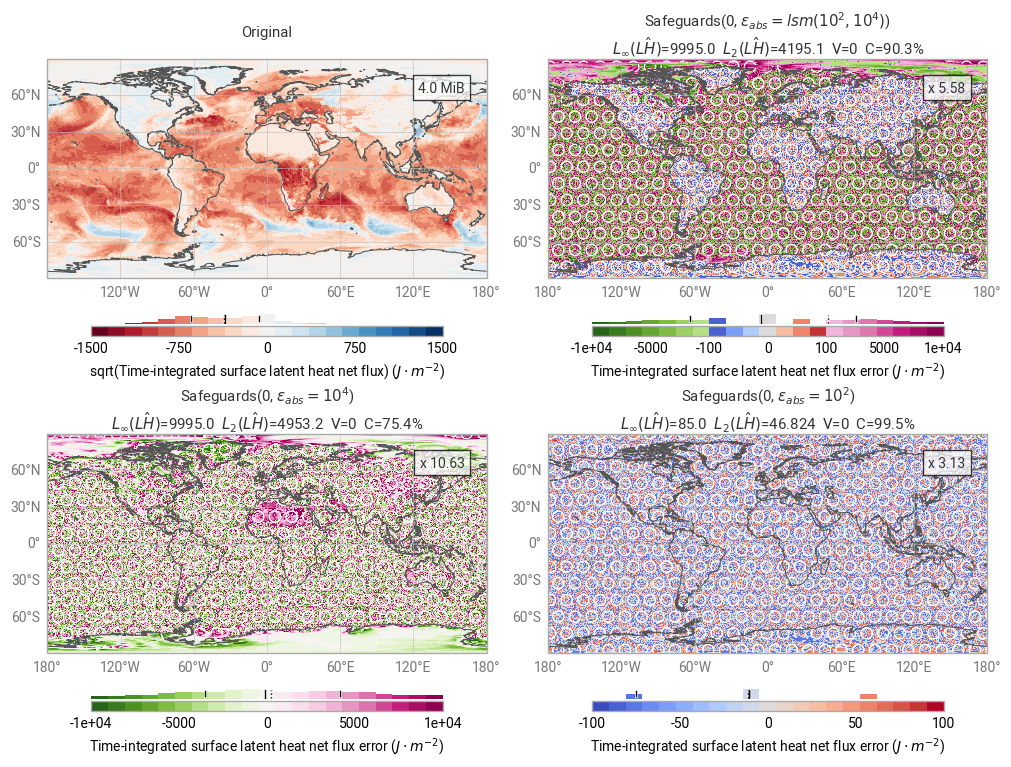

In [16]:
fig = earthkit.plots.Figure(rows=2, columns=2, size=(10, 7.5))

plot_surface_latent_heat_flux(
    ERA5_LH,
    1.0,
    fig.add_map(0, 0),
    "Original",
    span=1.5e3,
    eb_abs=eb_high["eb"],
)
plot_surface_latent_heat_flux(
    ERA5_LH_sg_roi,
    ERA5_LH.nbytes / encoded_sg_roi.nbytes,
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{abs}}=lsm(10^{{2}}, 10^{{4}})$)",
    span=eb_high["eb"],
    eb_abs=np.where(ERA5_LSM.values >= 0.9, eb_low["eb"], eb_high["eb"]),
    error=True,
    colors=colors_roi,
    ticks=[-1e4, -5e3, -1e2, 0, 1e2, 5e3, 1e4],
    norm=mcolors.FuncNorm((roi_norm, roi_norm_inverse), vmin=-1e4, vmax=1e4),
    corr=correction_sg_roi,
)

plot_surface_latent_heat_flux(
    ERA5_LH_sg_high,
    ERA5_LH.nbytes / encoded_sg_high.nbytes,
    fig.add_map(1, 0),
    r"Safeguards(0, $\epsilon_{{abs}}=10^{{4}}$)",
    span=eb_high["eb"],
    eb_abs=eb_high["eb"],
    error=True,
    colors="PiYG_r",
    corr=correction_sg_high,
)
plot_surface_latent_heat_flux(
    ERA5_LH_sg_low,
    ERA5_LH.nbytes / encoded_sg_low.nbytes,
    fig.add_map(1, 1),
    r"Safeguards(0, $\epsilon_{{abs}}=10^{{2}}$)",
    span=eb_low["eb"],
    eb_abs=eb_low["eb"],
    error=True,
    colors="coolwarm",
    corr=correction_sg_low,
)

fig.save("latent-heat-flux.pdf")